# E2: Applying Transformers to the Corpus

This notebook is used to apply and analyze measures on the Switchboard corpus via a series of ConvoKit Transformers.

### Import dependencies and load corpus

In [1]:
import os
os.chdir("../../") # import convokit
from convokit import Corpus, User, Utterance
os.chdir("datasets/switchboard-corpus") # then come back for switchboard
import convokit
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

In [2]:
# Load the switchboard corpus
corpus = convokit.Corpus(filename = "./corpus")

In [3]:
# Function to use for tokenizing utterances
def tokenize_utt(utterance: str):
    # Strips punctuation from utterance and returns a list of tokens
    tokenizer = RegexpTokenizer(r'\w+')	
    tokens = tokenizer.tokenize(utterance)

    # Remove any tokens that are a single letter other than 'I' or 'a'
    # because they are tags for the utterance tree
    for t in tokens:
        if len(t) == 1 and not (t == 'I' or t == 'a'):
            tokens.remove(t)
    return tokens

### Apply all the transformers

In [4]:
# Apply the ConversationBalance transformer
cb = convokit.ConversationBalance()
cb.transform(corpus)

In [5]:
# Apply the VocabOverlap transformer
vo = convokit.VocabOverlap()
vo.transform(corpus)

In [6]:
# Apply the vaderSentiment transformer
fi = convokit.VaderSentiment()
fi.transform(corpus)

In [7]:
# Apply the DAMSLScores transformer
ds = convokit.DAMSLScores('../../convokit/damslScores/damsl_rubric.txt')
ds.transform(corpus)

### Measure 1: Conversation Balance

Let's confirm the changes to the corpus one-by-one. The conversation balance is saved as an array of size NxN where N is the number of users. Cell (X,Y) in the array is the ratio of number of tokens said by User A to the total number of tokens.

In [29]:
for i, c in enumerate(corpus.iter_conversations()):
    balance = c.meta['conversation_balance']
    print(i+1,')  Balance from User 1 to User 2:', balance[0,1])
    
    if i == 2:
        break
        
print('We can see from this that the balance of convo 1 is the best because it is closest to 1')
print('Conversation 2 is less balanced')
print('Conversation 3 is more balanced, like Conversation 1.')

1 )  Balance from User 1 to User 2: 0.9138920780711826
2 )  Balance from User 1 to User 2: 0.6685185185185185
3 )  Balance from User 1 to User 2: 0.847682119205298
We can see from this that the balance of convo 1 is the best because it is closest to 1
Conversation 2 is less balanced
Conversation 3 is more balanced, like Conversation 1.


Let's look at the balance within a conversation. Here, we will call each group of consecutive utterances by the same User a statement. The statement balance is stored in the first utterance of a statement. It tells us the ratio of tokens of the current statement to the sum of the current statement's tokens and the next statement's tokens.

In [9]:
# Looking at just one conversation:
print('Users in this conversation:', corpus.conversations['2095-0']._usernames)

print('\nHere are the IDs for the first 5 utterances of the conversation, and the balance from',
     '\nthis utterance to the next:')
utt_list = corpus.conversations['2095-0']._utterance_ids
for i, u in enumerate(utt_list):
    if 'statement_balance' in corpus.utterances[u].meta:
        print(u, corpus.utterances[u].meta['statement_balance'])
        
    if i > 4:
        break
    

Users in this conversation: ['1169', '1221']

Here are the IDs for the first 5 utterances of the conversation, and the balance from 
this utterance to the next:
2095-0 0.9473684210526315
2095-1 0.18181818181818182
2095-3 0.07407407407407407
2095-4 0.7428571428571429
2095-5 0.4


For this conversation, let's see how the statement balance plots over the length of the conversation

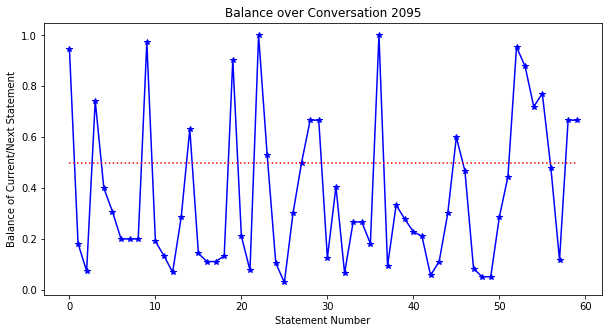

In [10]:
utt_list = corpus.conversations['2095-0']._utterance_ids
statement_ids = []
statement_balances = []

for u in utt_list:
    if 'statement_balance' in corpus.utterances[u].meta:
        statement_ids.append(u)
        statement_balances.append(corpus.utterances[u].meta['statement_balance'])
    
plt.figure(figsize=(10,5))
plt.plot(range(len(statement_balances)), statement_balances, 'b*-')
plt.plot(range(len(statement_balances)), 0.5*np.ones(len(statement_balances)), 'r:')
plt.title('Balance over Conversation 2095')
plt.xlabel('Statement Number')
plt.ylabel('Balance of Current/Next Statement')
plt.show()

What is the average balance over the first 10% of each conversation?

In [11]:
beg_balance = []
rest_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split = round(0.1*len(statement_balances))

    beginning = statement_balances[:split]
    rest = statement_balances[split:]
    assert(len(beginning)+len(rest) == len(statement_balances))
    beg_balance.append(sum(beginning)/len(beginning))
    rest_balance.append(sum(rest)/len(rest))
        
print('The average balance of the first 10% of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the rest of the conversation is:', sum(rest_balance)/len(rest_balance))

The average balance of the first 10% of the conversation is: 0.3827961520109395
The average balance of the rest of the conversation is: 0.3609941861544027


Based on this, it doesn't seem as though the first 10% of a conversation has a different balance than the rest. Let's look at the balance in other parts of the conversation.

In [30]:
beg_balance = []
rest_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])

    # Split up the statements to different parts of the conversation
    beginning = statement_balances[:2]
    rest = statement_balances[2:]
    assert(len(beginning)+len(rest) == len(statement_balances))
    beg_balance.append(sum(beginning)/len(beginning))
    rest_balance.append(sum(rest)/len(rest))
        
print('The average balance of the first exchange of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the rest of the conversation is:', sum(rest_balance)/len(rest_balance))
print('The balance here goes down. This may be because the first exchange may be a more equal introduction, while\
the rest of the conversation is the receiver answering questions by the caller.')

The average balance of the first exchange of the conversation is: 0.4274807805916815
The average balance of the rest of the conversation is: 0.3616616043620027
The balance here goes down. This may be because the first exchange may be a more equal introduction, whilethe rest of the conversation is the receiver answering questions by the caller.


In [13]:
beg_balance = []
mid_balance = []
end_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split1 = round(0.2*len(statement_balances))
    split2 = round(0.8*len(statement_balances))

    beginning = statement_balances[:split1]
    middle = statement_balances[split1:split2]
    end = statement_balances[split2:]
    
    assert(len(beginning)+len(middle)+len(end) == len(statement_balances))
    
    beg_balance.append(sum(beginning)/len(beginning))
    mid_balance.append(sum(middle)/len(middle))
    end_balance.append(sum(end)/len(end))
        
print('The average balance of the beginning of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the middle of the conversation is:', sum(mid_balance)/len(mid_balance))
print('The average balance of the end of the conversation is:', sum(end_balance)/len(end_balance))

The average balance of the beginning of the conversation is: 0.36899817451767136
The average balance of the middle of the conversation is: 0.3531537374993857
The average balance of the end of the conversation is: 0.3873200528958495


There is also very little difference between the middle and end of the conversation. It may be that there is no general pattern in conversation balance in this dataset.

### Measure 2: Overlapping use of vocabulary

Next we move onto use of overlapping vocabulary. Our hypothesis is that people tend to repeat what the other person says if the users are more engaged in the conversation. This measurement computes the proportion of tokens that are used by all users, while excluding stop words commonly used such as 'a', 'is', and 'or'.

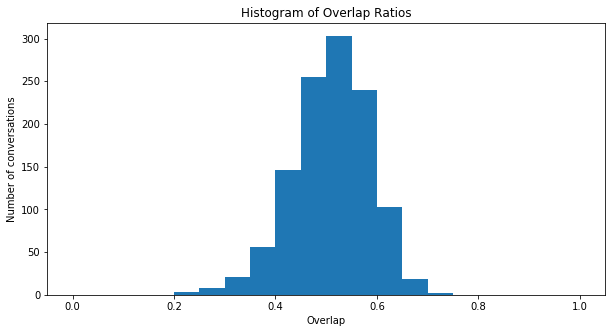

Mean = 0.509310 / StDev = 0.075667


In [14]:
overlaps = []
for i, convo in enumerate(corpus.iter_conversations()):
    overlaps.append(convo.meta['vocabulary_overlap']['ratio'])

        
plt.figure(figsize=(10,5))
plt.hist(overlaps, bins = np.linspace(0,1,num=21))
plt.title('Histogram of Overlap Ratios')
plt.xlabel('Overlap')
plt.ylabel('Number of conversations')
plt.show()

print('Mean = %f / StDev = %f' % (np.mean(overlaps), np.std(overlaps)))

From the histogram above, we see that the overlap ratio in conversations ranges within 0.2 to 0.8.

In [15]:
# Observe what words are overlapping across different users
for i, convo in enumerate(corpus.iter_conversations()):
    
    vo = convo.meta['vocabulary_overlap']
    print('+ Overlapping words in convo %s: %s\n' % (convo.id, vo['vocab']))
    if i == 2:
        break

+ Overlapping words in convo 4325-0: {'usually', 'like', 'get', 'lucky', 'different', 'home', 'large', 'care', 'one', 'right', 'never', 'though', 'day', 'um', 'real', 'know', 'watch', 'yeah', 'sister', 'yes', 'place', 'time', 'uh', 'laughter', 'kind', 'think', 'would', 'okay', 'oh', 'work', 'community', 'really', 'starts', 'well', 'something', 'huh', 'kids', 'take'}

+ Overlapping words in convo 4330-0: {'policies', 'got', 'engineer', 'mean', 'screening', 'people', 'like', 'get', 'interesting', 'lot', 'right', 'test', 'since', 'drug', 'random', 'um', 'know', 'even', 'rigs', 'policy', 'uh', 'tested', 'job', 'company', 'laughter', 'subjected', 'kind', 'go', 'equipment', 'testing', 'work', 'guess', 'really', 'parties', 'little', 'well', 'drugs', 'case', 'nature', 'something', 'huh'}

+ Overlapping words in convo 4103-0: {'payroll', 'got', 'point', 'balanced', 'goals', 'like', 'get', 'going', 'college', 'recently', 'use', 'interesting', 'keep', 'lot', 'put', 'one', 'range', 'bit', 'check',

We see that using just stop words still leaves some commonly used words with less content. Also, repeated usage of rare words should be more significant for our purpose, and thus one potential improvement from here would be to apply an additional filter that only keeps content words.

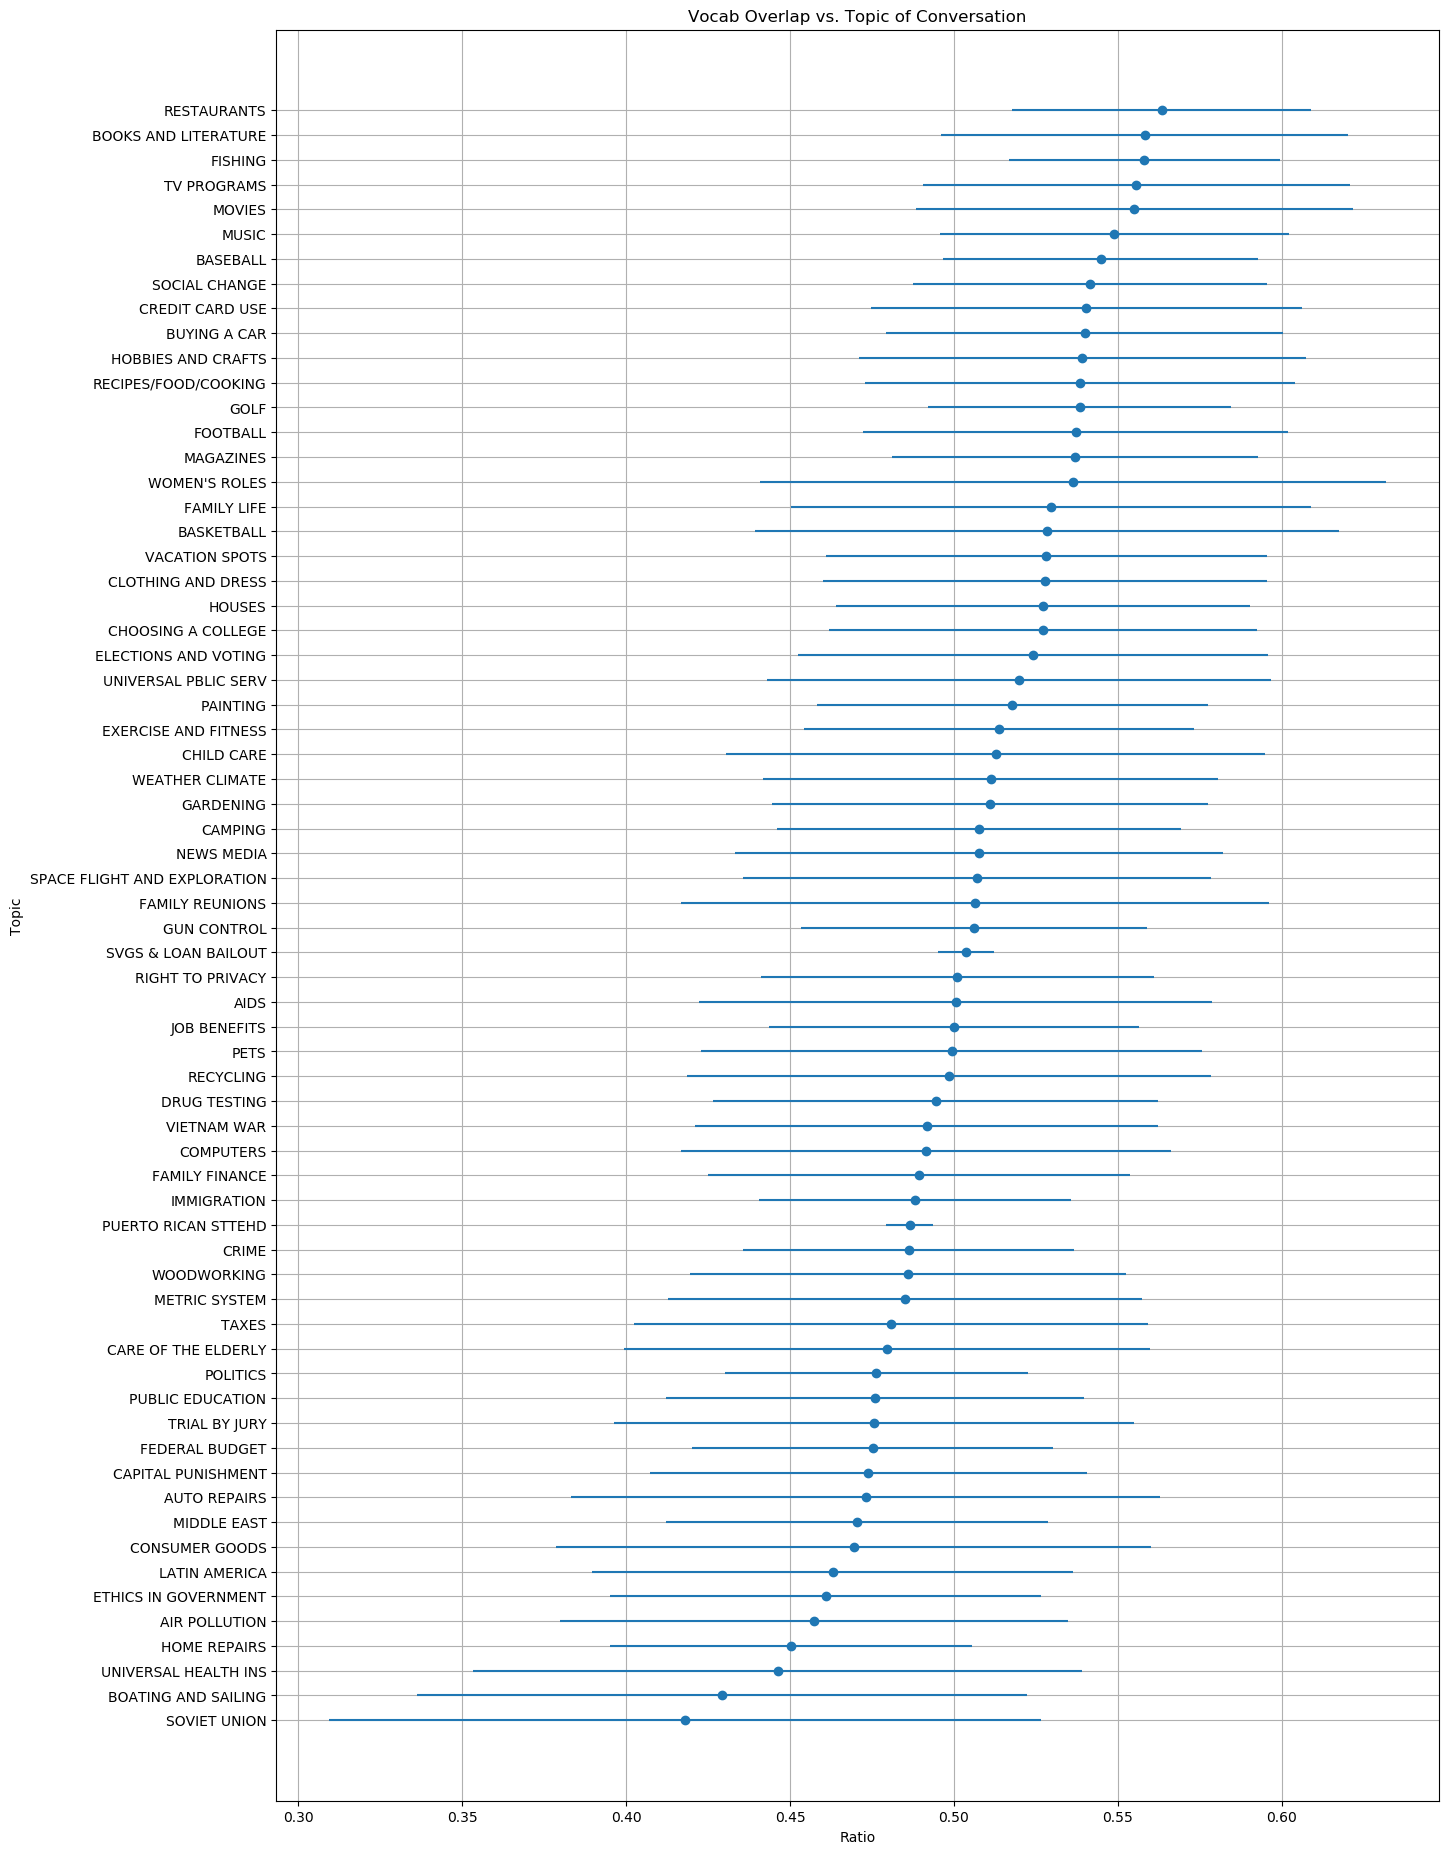

In [16]:
# Investigate whether different topics of conversaition leads to
# more or less overlapping vocabulary amongst the users
topicCounts = {}
topicOverlap = {}
for conv_id in corpus.meta['metadata']:
    
    topic = corpus.meta['metadata'][conv_id]['topic_description']
    
    convo = corpus.conversations[conv_id + '-0']
    overlap = convo.meta['vocabulary_overlap']['ratio']
    
    if topic not in topicCounts:
        topicCounts[topic] = 1
        topicOverlap[topic] = [overlap]
    else:
        topicCounts[topic] += 1
        topicOverlap[topic].append(overlap)

means = []
stds = []
for overlap in topicOverlap.values():
    means.append(np.mean(overlap))
    stds.append(np.std(overlap))
        
# Sort by the average vocab overlap
idx = np.argsort(means)
    
# Plot politeness scores for each topic (error bar showing 1 standard deviation)
x = np.arange(len(means))

means = np.array(means)
stds = np.array(stds)

plt.rcdefaults()
plt.figure(figsize=(15, 23))
plt.errorbar(means[idx], x, xerr=stds[idx], linestyle='None', marker='o')
plt.yticks(x, [list(topicOverlap.keys())[i] for i in idx])
plt.grid()
plt.title('Vocab Overlap vs. Topic of Conversation')
plt.xlabel('Ratio')
plt.ylabel('Topic')
plt.show()

Here, we see an interesting trend in which easily accessible topics such as fishing, movies, and baseball show larger overlap within vocabularies, whereas topics requiring rather more knowledge such as soviet union, ethics in government, and air pollution show less overlap.

### Measure 3: Scores measured with DAMSL tags

Among 43 different DAMSL act-tags shown in Table 3 of http://compprag.christopherpotts.net/swda.html, we believe some tags are indicative of engaging and useful interactions within conversations (e.g. acknowledgement or reformulation), whereas others indicate less-quality conversations (e.g. Uninterpretable or 3rd-party talk). 

By checking example utterances with each tag, we classified each tag by hand, after which each tag has a score based on its indication: +1 (good interaction), 0 (neutral), and -1 (bad interaction). This hand-crafted rubric can be found in `/convokit/damslScores/damsl_rubric.txt`. Out of 43 DAMSL tags, 15 tags are marked as +1, 8 tags as -1, and 20 tags as 0. The final DAMSL score stored in the conversation-level metadata under key `damsl_score` is simply the average of the scores across all utterances within the conversation.

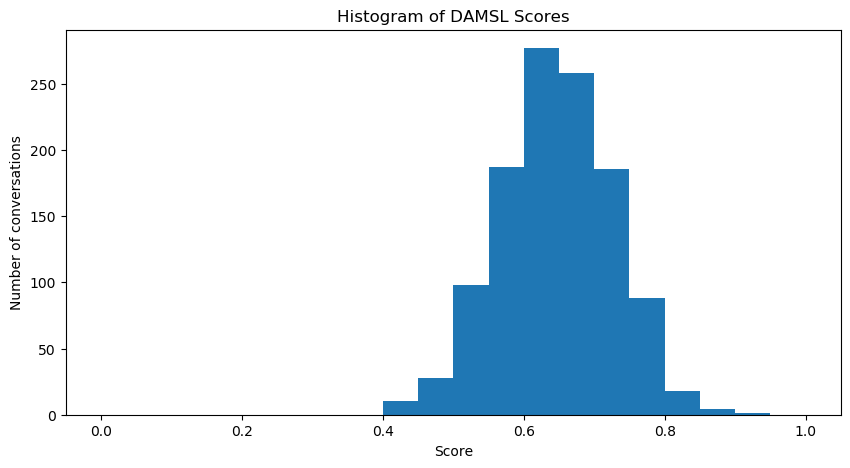

Mean = 0.646245 / StDev = 0.079723


In [17]:
scores = []
for i, convo in enumerate(corpus.iter_conversations()):
    scores.append(convo.meta['damsl_score'])
    
plt.figure(figsize=(10,5))
plt.hist(scores, bins = np.linspace(0,1,num=21))
plt.title('Histogram of DAMSL Scores')
plt.xlabel('Score')
plt.ylabel('Number of conversations')
plt.show()

print('Mean = %f / StDev = %f' % (np.mean(scores), np.std(scores)))

We see that all scores reside on the positive side, which is expected as we have almost twice as many tags as +1 than as -1. The most frequent tags are mostly tagged as +1, further pushing the average towards the positive side.

Instead of hand-crafting the points naively as +1 or -1, it would be helpful to have a DAMSL-tagged dataset with human-annotated conversation quality scores, with which we can build a regression model to learn the suitable weights of each tag.

In [18]:
# Sample conversations with lowest and highest DAMSL scores according to our rubric
min_score = 1
max_score = 0
for convo in corpus.iter_conversations():
    if convo.meta['damsl_score'] > max_score:
        max_score = convo.meta['damsl_score']
        max_convo = convo
    elif convo.meta['damsl_score'] < min_score:
        min_score = convo.meta['damsl_score']
        min_convo = convo

print('+ Sample text from conversation with lowest DAMSL score:')
curr_user = ''
curr_statement = []
for idx, utt in enumerate(min_convo.iter_utterances()):
    tokens = tokenize_utt(utt.text)
    if utt.user.name == curr_user:
        curr_statement += tokens
    else:
        if curr_user != '':
            print('-User %s: %s' % (curr_user, ' '.join(curr_statement)))
        curr_user = utt.user.name
        curr_statement = tokens
    if idx > 50:
        break

        
print('\n\n+ Sample text from conversation with highest DAMSL score:')
curr_user = ''
curr_statement = []
for idx, utt in enumerate(max_convo.iter_utterances()):
    tokens = tokenize_utt(utt.text)
    if utt.user.name == curr_user:
        curr_statement += tokens
    else:
        if curr_user != '':
            print('-User %s: %s' % (curr_user, ' '.join(curr_statement)))
        curr_user = utt.user.name
        curr_statement = tokens
    if idx > 50:
        break

+ Sample text from conversation with lowest DAMSL score:
-User 1357: The question was on lawn and garden work Um how do you like it
-User 1361: Well I don do much of it here I from uh Te from uh Colorado originally and there are no bugs there And I didn mind getting in the dirt there but boy I ll tell you what once I see these bugs around here I just kind of out of it
-User 1357: Oh what kind do you have Laughter
-User 1361: Oh roaches and
-User 1357: Do they really
-User 1361: Oh yes Cockroaches are awful here
-User 1357: Oh
-User 1361: Just awful So I
-User 1357: Oh and I know somebody that lives there and they never mentioned that problem laughter
-User 1361: Oh you re kidding you re kidding No it a well maybe they didn mention it because it just kind of a fact of life around here And uh
-User 1357: Oh my They probably just take it for granted then
-User 1361: It must be If they lived here a lot of people I know just say oh I just baby stomp on them It doesn matter They make good fe

### Measure 4: Sentiment analysis for first impressions

Lastly, we perform sentiment analysis on the utterances that cover the first 10% of each conversation, to represent how good or bad the users' first impressions were. We use the pretrained NLTK VADER sentiment analyzer, in which there are four metrics:
- `neg/neu/pos`: These represent the negative/neutral/positive sentiments of an utterance/conversation. Each of these range within [0,1], and the three sums up to 1.
- `compound`: This aggregated score ranges from -1 (extreme negative) to +1 (extreme positive), and is computed by iterating through a lexicon with several heuristics. For further detail, please refer to http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf. We will mainly use this metric to check our hypothesis.

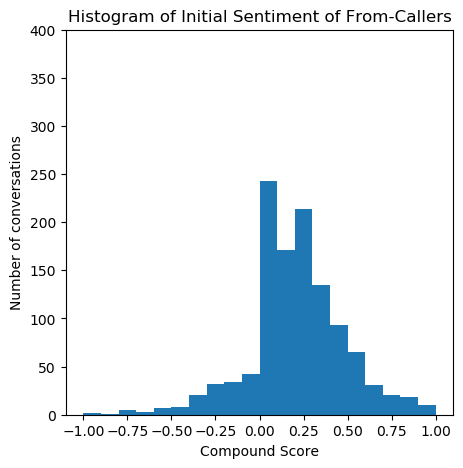

Mean = 0.198901 / StDev = 0.275779


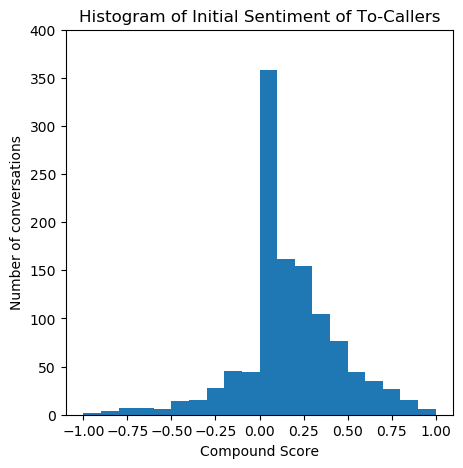

Mean = 0.153019 / StDev = 0.285121


In [19]:
compoundsFrom = []
compoundsTo = []
for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    compoundsFrom.append(convo.meta['initial_sentiment'][from_caller]['compound'])
    compoundsTo.append(convo.meta['initial_sentiment'][to_caller]['compound'])
    
    
plt.figure(figsize=(5,5))
plt.hist(compoundsFrom, bins = np.linspace(-1,1,num=21))
plt.title('Histogram of Initial Sentiment of From-Callers')
plt.xlabel('Compound Score')
plt.ylabel('Number of conversations')
plt.ylim(bottom=0, top=400)
plt.show()
print('Mean = %f / StDev = %f' % (np.mean(compoundsFrom), np.std(compoundsFrom)))


plt.figure(figsize=(5,5))
plt.hist(compoundsTo, bins = np.linspace(-1,1,num=21))
plt.title('Histogram of Initial Sentiment of To-Callers')
plt.xlabel('Compound Score')
plt.ylabel('Number of conversations')
plt.ylim(bottom=0, top=400)
plt.show()
print('Mean = %f / StDev = %f' % (np.mean(compoundsTo), np.std(compoundsTo)))


Results show that the sentiment of to-callers have slightly more negative sentiments at the beginning of a conversation. This behavior is expected, as it is the from-caller's intention to call the recepient, and there may be situations where the to-caller would prefer not to start the whole conversations.

In [20]:
# Print out sample initial utterances for sanity-check
i = 0
for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    print('+ Conversation %s (neg/neu/pos/compound)' % k)
    print('- Sentiment scores of from-caller (%s) = %f/%f/%f/%f' % (from_caller, convo.meta['initial_sentiment'][from_caller]['neg'],\
                                                                   convo.meta['initial_sentiment'][from_caller]['neu'],\
                                                                   convo.meta['initial_sentiment'][from_caller]['pos'],\
                                                                   convo.meta['initial_sentiment'][from_caller]['compound']))
    print('- Sentiment scores of to-caller (%s) = %f/%f/%f/%f' % (from_caller, convo.meta['initial_sentiment'][to_caller]['neg'],\
                                                                   convo.meta['initial_sentiment'][to_caller]['neu'],\
                                                                   convo.meta['initial_sentiment'][to_caller]['pos'],\
                                                                   convo.meta['initial_sentiment'][to_caller]['compound']))
    print('- Sample beginning text:')
    for idx, utt in enumerate(convo.iter_utterances()):
        tokens = tokenize_utt(utt.text)
        if utt.user.name == from_caller:
            print('  (FROM): %s' % ' '.join(tokens))
        else:
            print('  ( TO ): %s' % ' '.join(tokens))
        if idx > 15:
            break
            
    print('\n')
    i += 1
    if i > 4:
        break

+ Conversation 4325 (neg/neu/pos/compound)
- Sentiment scores of from-caller (1632) = 0.000000/0.416500/0.583500/0.249750
- Sentiment scores of to-caller (1632) = 0.000000/0.799000/0.201000/0.361350
- Sample beginning text:
  (FROM): Okay
  (FROM): So
  ( TO ): I guess
  (FROM): What kind of experience do you do you have then with child care
  ( TO ): I think uh I wonder if that worked
  (FROM): Does it say something
  ( TO ): I think it usually does
  ( TO ): You might try uh
  ( TO ): I don know
  ( TO ): hold it down a little longer
  ( TO ): and see if it uh
  (FROM): Okay beep
  (FROM): long pause Well
  ( TO ): Okay
  ( TO ): I
  (FROM): Does it usually make a recording or
  ( TO ): Well I don remember


+ Conversation 4330 (neg/neu/pos/compound)
- Sentiment scores of from-caller (1635) = 0.000000/0.913000/0.087000/0.136600
- Sentiment scores of to-caller (1635) = 0.000000/1.000000/0.000000/0.000000
- Sample beginning text:
  (FROM): Well uh does the company you work for test for

From conversations 4327 and 4646, we see that the way NLTK VADER assigns sentiment polarity scores is a bit different from how we would interpret conversation sentiments as negative. In addition to detecting negative emotion or behavior among participants, the analyzer assesses certain topics such as "Alzheimer's" or "murder" as negative, assigning negative compound polarity scores despite the conversation involving no hostility whatsoever. 

This may also imply that this analyzer is not suitable for our purpose, as what we really need is one's sentiment towards the other participant, not necessarily towards the topic under consideration. Given that this dataset is constructed from conversations between two people who have met for the first time, we would rarely see a user showing bad impressions towards others, and the analyzer would depend mostly on the topics. To see this is indeed the case, we plot the average compound scores for each topic as well.

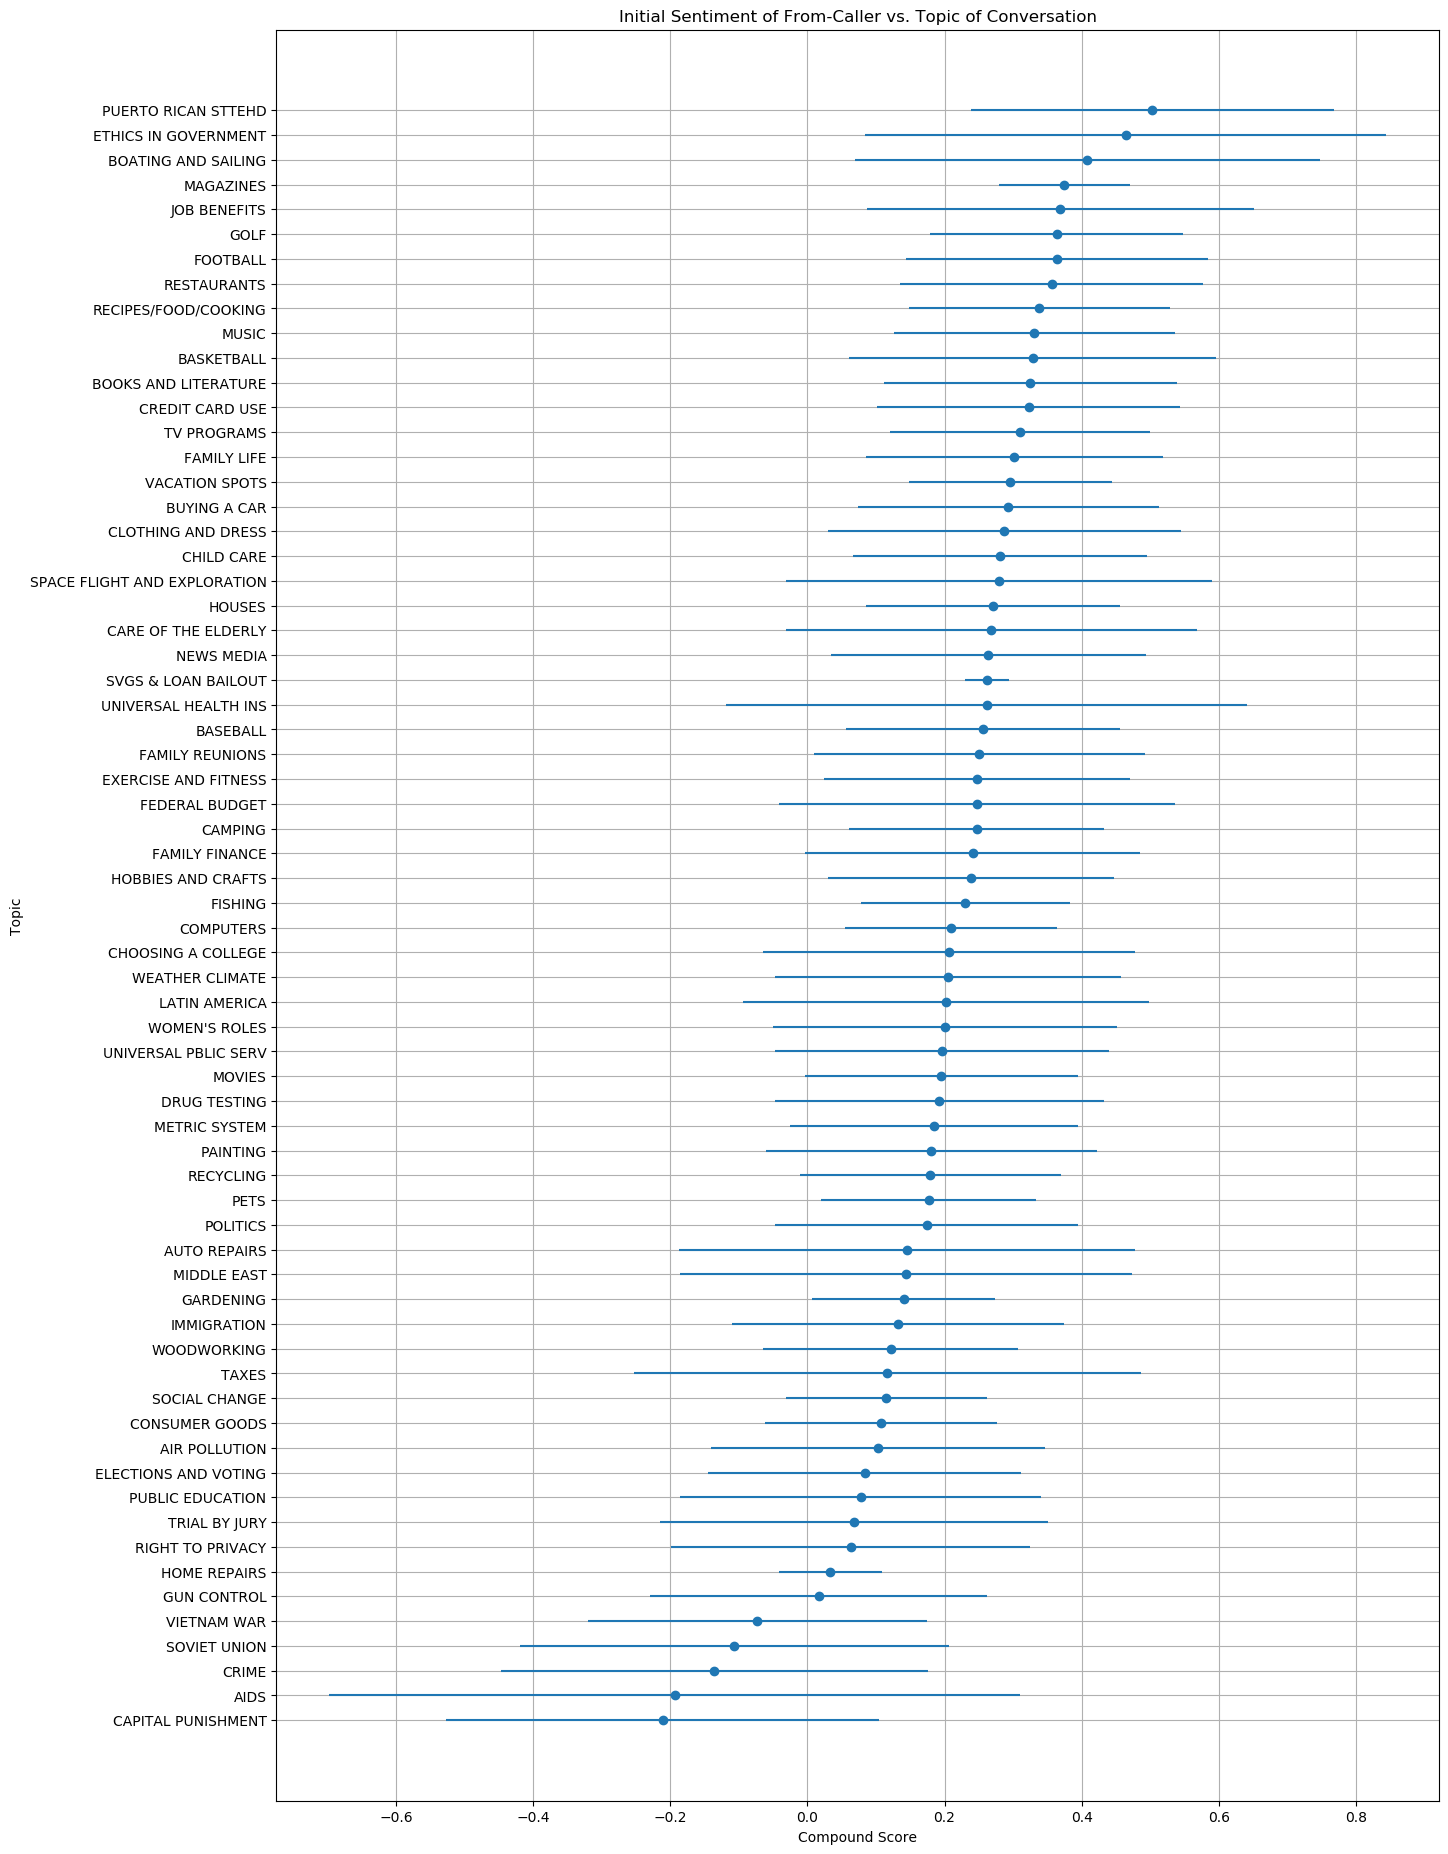

In [21]:
# Investigate whether different topics of conversaition leads to
# more or less overlapping vocabulary amongst the users
topicCounts = {}
topicSentiment = {}
for conv_id in corpus.meta['metadata']:
    
    topic = corpus.meta['metadata'][conv_id]['topic_description']
    from_caller = corpus.meta['metadata'][conv_id]['from_caller']
    
    convo = corpus.conversations[conv_id + '-0']
    compound = convo.meta['initial_sentiment'][from_caller]['compound']
    
    if topic not in topicCounts:
        topicCounts[topic] = 1
        topicSentiment[topic] = [compound]
    else:
        topicCounts[topic] += 1
        topicSentiment[topic].append(compound)

means = []
stds = []
for compound in topicSentiment.values():
    means.append(np.mean(compound))
    stds.append(np.std(compound))
        
# Sort by the average vocab overlap
idx = np.argsort(means)
    
# Plot politeness scores for each topic (error bar showing 1 standard deviation)
x = np.arange(len(means))

means = np.array(means)
stds = np.array(stds)

plt.rcdefaults()
plt.figure(figsize=(15, 23))
plt.errorbar(means[idx], x, xerr=stds[idx], linestyle='None', marker='o')
plt.yticks(x, [list(topicOverlap.keys())[i] for i in idx])
plt.grid()
plt.title('Initial Sentiment of From-Caller vs. Topic of Conversation')
plt.xlabel('Compound Score')
plt.ylabel('Topic')
plt.show()

## Checking our main hypothesis

We mainly hypothesized that the first impression starting a conversation is positively correlated to the quality of the entire conversation. If the caller starts the conversation with a kind introduction with a positive tone, we would expect the receiver to be more likely to respond in a similar manner and answer the caller's questions with more detail. Conversely, if the introduction is terse and abrupt, the receiver will be less likely to cooperate or to provide thought-out and detailed responses. In essence, we test to see if measure 4 (sentiment analysis) has any correlation with the other three measurements.

### Vader Sentiment vs. Conversation Balance

We first check the correlation between the initial sentiment and the conversation balance. We use the deviation of the balance term from 0.5 to measure how good a conversation was (i.e. an ideal conversation would have 0 deviation).

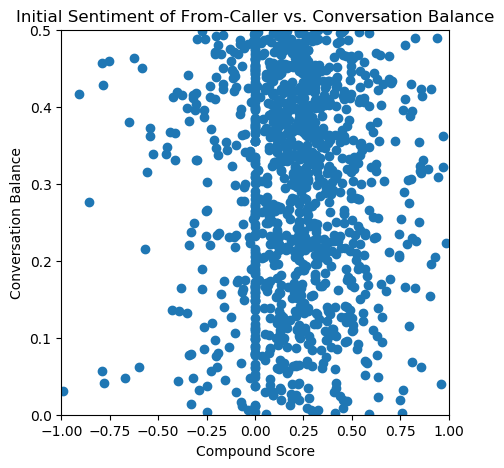

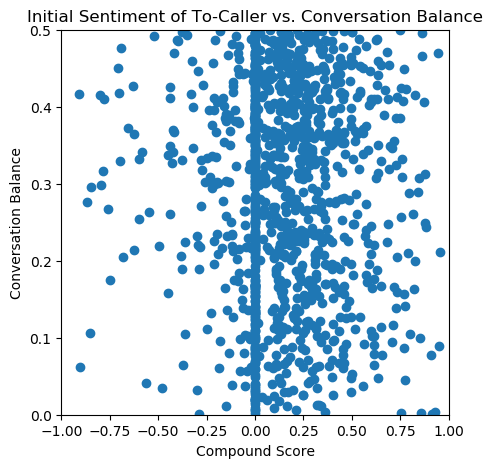

In [22]:
convoBalances = []
compoundsFrom = []
compoundsTo = []

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    
    # We measure how far the conversation balance is far from 50-50
    convoBalances.append(abs(0.5-convo.meta['conversation_balance'][0,1]))
    
    compoundsFrom.append(convo.meta['initial_sentiment'][from_caller]['compound'])
    compoundsTo.append(convo.meta['initial_sentiment'][to_caller]['compound'])

plt.figure(figsize=(5,5))
plt.scatter(compoundsFrom, convoBalances)
plt.title('Initial Sentiment of From-Caller vs. Conversation Balance')
plt.xlabel('Compound Score')
plt.xlim([-1,1])
plt.ylabel('Conversation Balance')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(compoundsTo, convoBalances)
plt.title('Initial Sentiment of To-Caller vs. Conversation Balance')
plt.xlabel('Compound Score')
plt.xlim([-1,1])
plt.ylabel('Conversation Balance')
plt.ylim([0,0.5])
plt.show()

### First Impression vs. Overlapping use of vocab

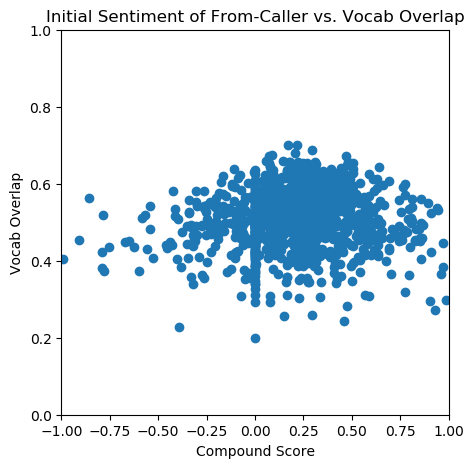

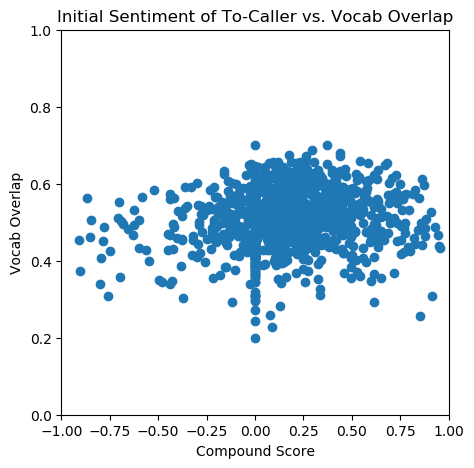

In [23]:
overlaps = []
compoundsFrom = []
compoundsTo = []

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    
    overlaps.append(convo.meta['vocabulary_overlap']['ratio'])
    
    compoundsFrom.append(convo.meta['initial_sentiment'][from_caller]['compound'])
    compoundsTo.append(convo.meta['initial_sentiment'][to_caller]['compound'])

plt.figure(figsize=(5,5))
plt.scatter(compoundsFrom, overlaps)
plt.title('Initial Sentiment of From-Caller vs. Vocab Overlap')
plt.xlabel('Compound Score')
plt.xlim([-1,1])
plt.ylabel('Vocab Overlap')
plt.ylim([0,1])
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(compoundsTo, overlaps)
plt.title('Initial Sentiment of To-Caller vs. Vocab Overlap')
plt.xlabel('Compound Score')
plt.xlim([-1,1])
plt.ylabel('Vocab Overlap')
plt.ylim([0,1])
plt.show()

### First impression vs. DAMSL act-tag scores

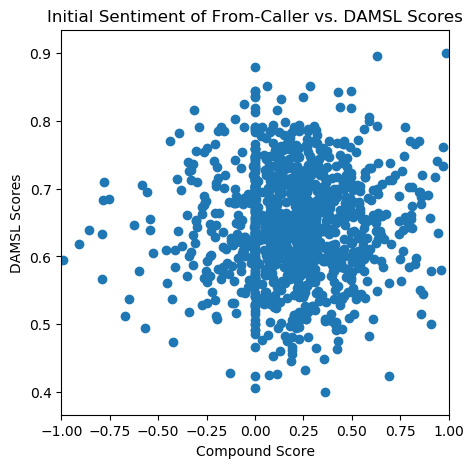

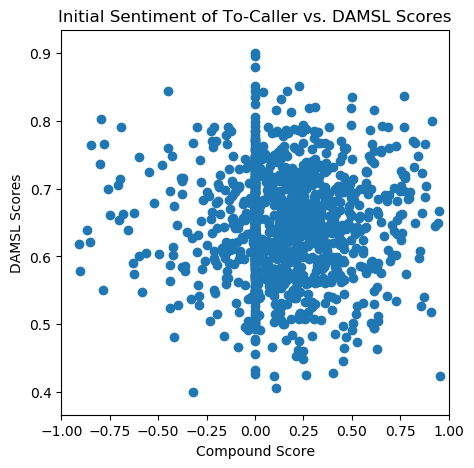

In [24]:
scores = []
compoundsFrom = []
compoundsTo = []

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    
    scores.append(convo.meta['damsl_score'])
    
    compoundsFrom.append(convo.meta['initial_sentiment'][from_caller]['compound'])
    compoundsTo.append(convo.meta['initial_sentiment'][to_caller]['compound'])

plt.figure(figsize=(5,5))
plt.scatter(compoundsFrom, scores)
plt.title('Initial Sentiment of From-Caller vs. DAMSL Scores')
plt.xlabel('Compound Score')
plt.xlim([-1,1])
plt.ylabel('DAMSL Scores')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(compoundsTo, scores)
plt.title('Initial Sentiment of To-Caller vs. DAMSL Scores')
plt.xlabel('Compound Score')
plt.xlim([-1,1])
plt.ylabel('DAMSL Scores')
plt.show()

### Change of Sentiment within Conversations

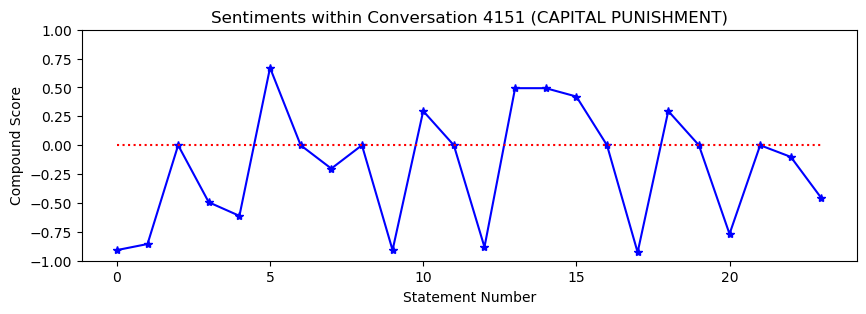

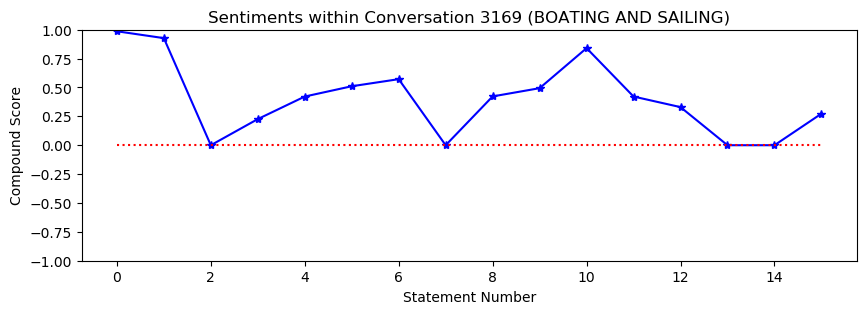

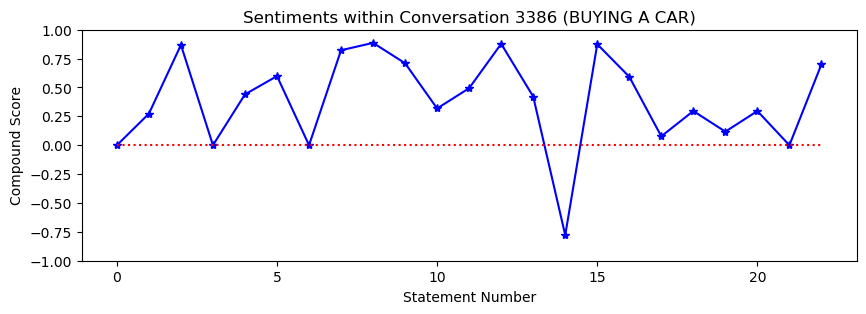

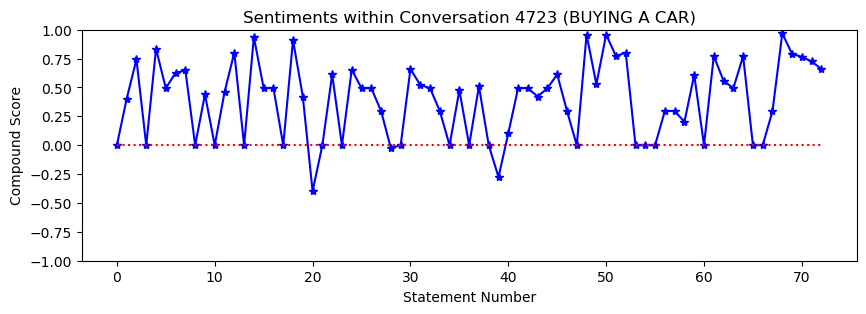

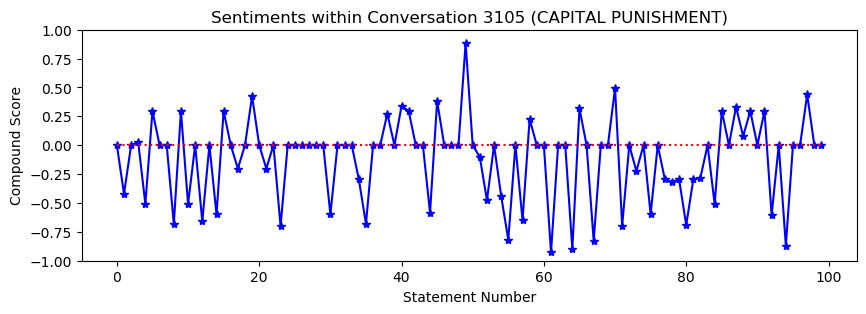

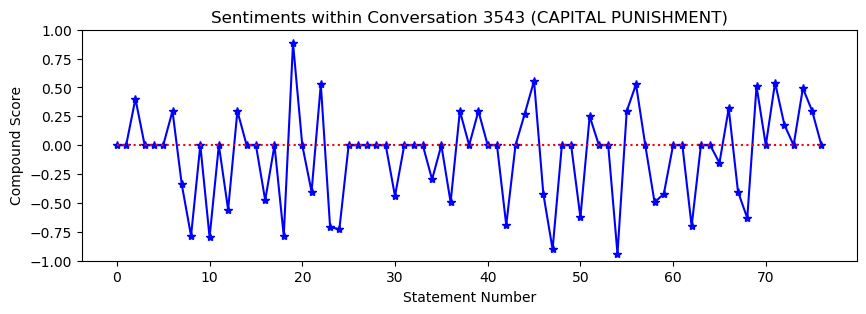

In [25]:
compoundsFrom = []
compoundsTo = []

i = 0

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    compounds = []
    
    #compoundsFrom.append(convo.meta['initial_sentiment'][from_caller]['compound'])
    #compoundsTo.append(convo.meta['initial_sentiment'][to_caller]['compound'])
    
    curr_user = from_caller
    st_compound = 0
    for utt in convo.iter_utterances():
        
        # append if statement is covered.
        if utt.user.name != curr_user:
            compounds.append(st_compound)
            curr_user = utt.user.name
        st_compound = utt.meta['polarity']['compound']
        
    compounds.append(st_compound)
    
    if i in [60, 715, 717, 669, 683, 182]:
        plt.figure(figsize=(10,3))
        plt.plot(range(len(compounds)), compounds, 'b*-')
        plt.plot(range(len(compounds)), np.zeros(len(compounds)), 'r:')
        plt.title('Sentiments within Conversation ' + k + ' (' + v['topic_description'] + ')')
        plt.xlabel('Statement Number')
        plt.ylabel('Compound Score')
        plt.ylim([-1, 1])
        plt.show()
    
    i += 1

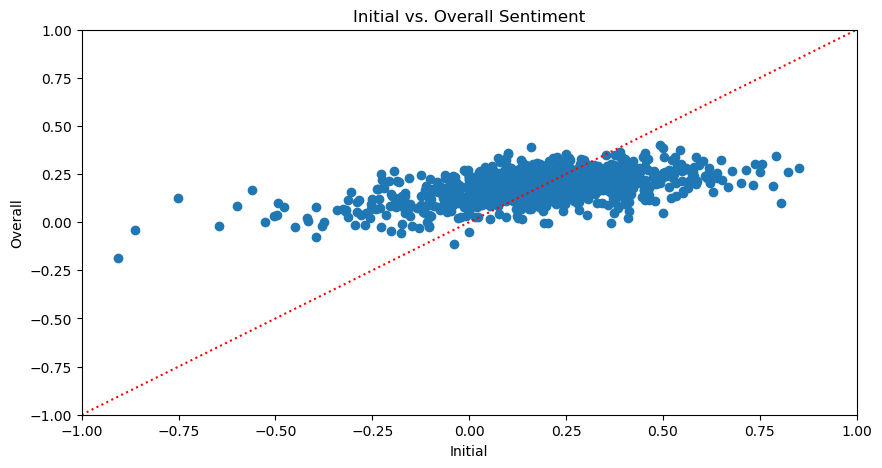

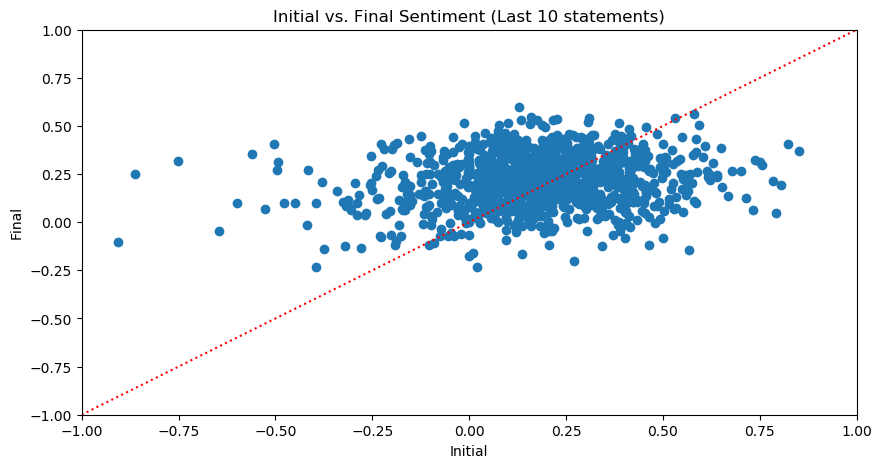

In [26]:
initialSentiments = []
overallSentiments = []
finalSentiments = []

i = 0

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    compounds = []
    
    from_compound = convo.meta['initial_sentiment'][from_caller]['compound']
    to_compound = convo.meta['initial_sentiment'][to_caller]['compound']
    initialSentiments.append((from_compound + to_compound)/2)
    
    curr_user = from_caller
    st_compound = 0
    for utt in convo.iter_utterances():
        
        # append if statement is covered.
        if utt.user.name != curr_user:
            compounds.append(st_compound)
            curr_user = utt.user.name
        st_compound = utt.meta['polarity']['compound']
        
    compounds.append(st_compound)
    overallSentiments.append(np.mean(compounds))
    finalSentiments.append(np.mean(compounds[-10:]))
    
plt.figure(figsize=(10,5))
plt.scatter(initialSentiments, overallSentiments)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Overall Sentiment')
plt.xlabel('Initial')
plt.ylabel('Overall')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(initialSentiments, finalSentiments)
plt.plot(range(-1,2), range(-1,2), 'r:')
plt.title('Initial vs. Final Sentiment (Last 10 statements)')
plt.xlabel('Initial')
plt.ylabel('Final')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

### Change in conversation balance within conversations

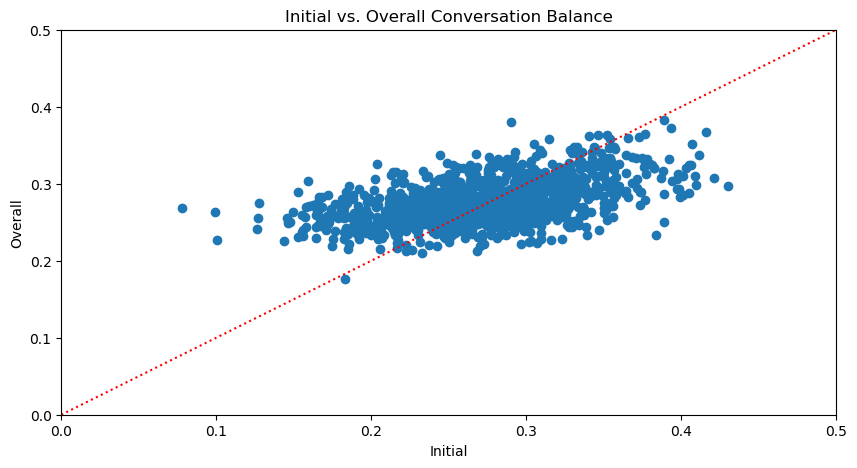

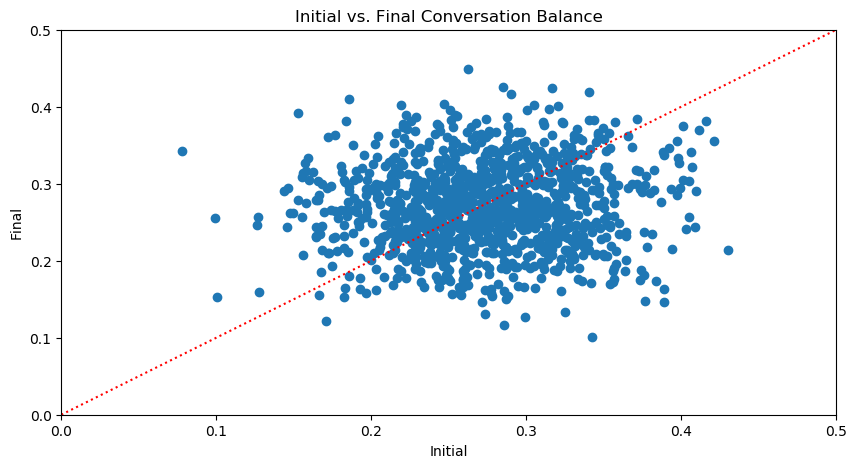

In [27]:
initialBalances = []
overallBalances = []
finalBalances = []

i = 0

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    balances = []
    
    convobalance = abs(0.5-convo.meta['conversation_balance'][0,1])
    
    curr_user = from_caller
    st_balance = 0
    for utt in convo.iter_utterances():
        try:
            balances.append(abs(0.5-utt.meta['statement_balance']))
        except KeyError:
            continue
    
    initialBalances.append(np.mean(balances[:10]))
    overallBalances.append(np.mean(balances))
    finalBalances.append(np.mean(balances[-10:]))
    
    
plt.figure(figsize=(10,5))
plt.scatter(initialBalances, overallBalances)
plt.plot(range(0,2), range(0,2), 'r:')
plt.title('Initial vs. Overall Conversation Balance')
plt.xlabel('Initial')
plt.ylabel('Overall')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(initialBalances, finalBalances)
plt.plot(range(0,2), range(0,2), 'r:')
plt.title('Initial vs. Final Conversation Balance')
plt.xlabel('Initial')
plt.ylabel('Final')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.show()


### Change in vocabulary overlap within conversations

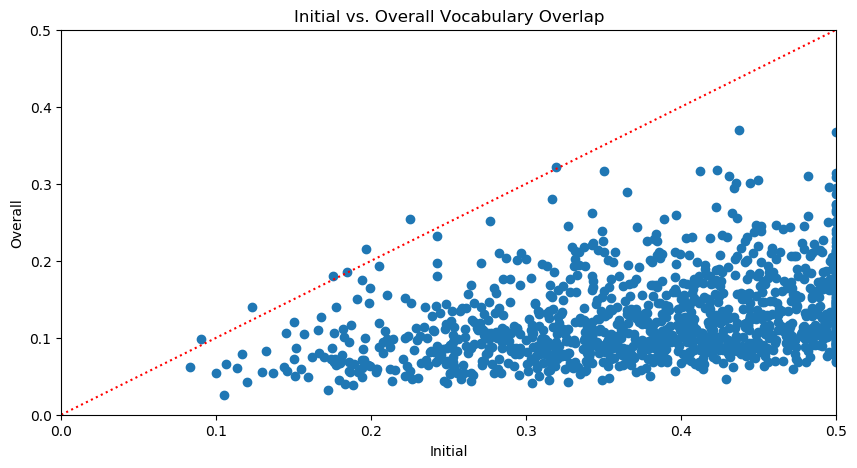

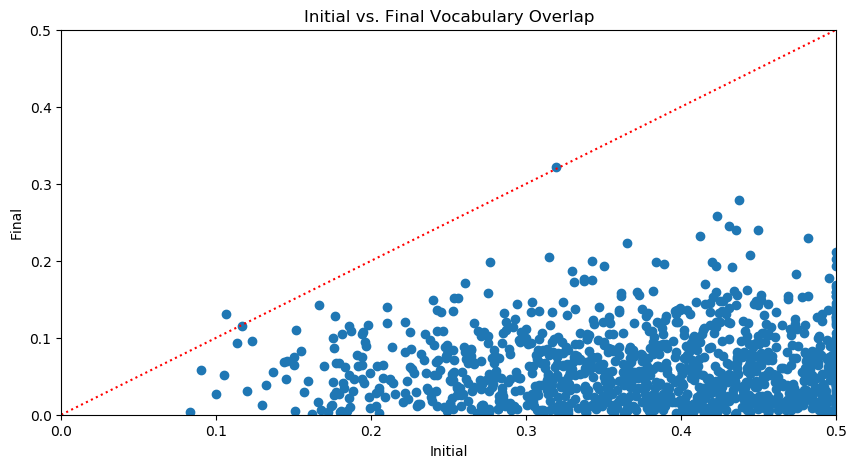

Vocabulary Overlap goes up to 50% overlap. The plots show that the initial overlap is muchless 
than the overall overlap. This makes sense because as the conversation goes on, people will use 
more vocabulary related to the conversation topic.


In [28]:
initialOverlap = []
overallOverlap = []
finalOverlap = []

i = 0

for k, v in corpus.meta['metadata'].items():
    
    from_caller = v['from_caller']
    to_caller = v['to_caller']
    convo = corpus.conversations[k+'-0']
    overlaps = []
    convobalance = abs(0.5-convo.meta['vocabulary_overlap']['ratio'])
    
    curr_user = from_caller
    st_overlap = 0
    for utt in convo.iter_utterances():
        try:
            overlaps.append(abs(0.5-utt.meta['vocabulary_overlap']['ratio']))
        except KeyError:
            continue
    
    initialOverlap.append(np.mean(overlaps[:10]))
    overallOverlap.append(np.mean(overlaps))
    finalOverlap.append(np.mean(overlaps[-10:]))
    
    
plt.figure(figsize=(10,5))
plt.scatter(initialOverlap, overallOverlap)
plt.plot(range(0,2), range(0,2), 'r:')
plt.title('Initial vs. Overall Vocabulary Overlap')
plt.xlabel('Initial')
plt.ylabel('Overall')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(initialOverlap, finalOverlap)
plt.plot(range(0,2), range(0,2), 'r:')
plt.title('Initial vs. Final Vocabulary Overlap')
plt.xlabel('Initial')
plt.ylabel('Final')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.show()

print('Vocabulary Overlap goes up to 50% overlap. The plots show that the initial overlap is much\
less \nthan the overall overlap. This makes sense because as the conversation goes on, people will\
 use \nmore vocabulary related to the conversation topic.')